# License

Copyright 2019 Navdeep Gill, Patrick Hall, Kim Montgomery, Nick Schmidt

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

**DISCLAIMER**: This notebook is not legal compliance advice.

In [52]:
import h2o
import os
import numpy as np
import time
import math
import matplotlib.pyplot as plt
import shap
import pandas as pd

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch 

# init h2o
h2o.init(min_mem_size='30G')
h2o.remove_all()

# set random seed for reproducibility
SEED = 22222

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,5 mins 57 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.9
H2O cluster version age:,1 month and 6 days
H2O cluster name:,H2O_from_python_navdeep_wno3ur
H2O cluster total nodes:,1
H2O cluster free memory:,28.28 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,40
H2O cluster status:,"locked, healthy"


In [53]:
train_path = os.sep.join(['..', 'data', 'output', 'hmda_train.csv'])
train = h2o.import_file(train_path)

test_path = os.sep.join(['..', 'data', 'output', 'hmda_test.csv'])
test = h2o.import_file(test_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [54]:
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (160338, 23)
Test shape: (39662, 22)


In [55]:
train.head()

C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,cv_fold
2.5493e+06,175000,97,1,0,185000,36,0,47,1,1,nan,nan,nan,nan,nan,nan,nan,1,0,1,0,1
4.00076e+06,265000,95,1,0,285000,100,0,nan,1,1,0,0,1,0,0,0,1,nan,nan,1,0,5
1.54693e+06,115000,97,0,120,125000,59,0,39,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,5
5.45314e+06,275000,57.9,1,0,475000,100,0,nan,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3
4.94313e+06,155000,99,1,0,155000,42,0,46,1,1,0,0,1,0,0,1,0,nan,nan,0,1,4
1.23729e+06,215000,95,1,0,225000,81,0,42,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3
682016,195000,95,1,0,205000,92,0,49,1,1,0,0,1,0,0,0,1,0,1,nan,nan,1
19740,125000,100,1,0,125000,38,0,43,1,1,0,0,1,0,0,0,1,1,0,nan,nan,2
5.36388e+06,355000,90,1,0,395000,95,0,38,1,1,0,0,1,0,0,0,1,nan,nan,0,1,5
1.94229e+06,595000,80,1,0,745000,371,0,nan,1,0,0,0,1,0,0,0,1,nan,nan,0,1,4


In [56]:
train.summary()

,C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,cv_fold
type,int,int,real,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,49.0,5000.0,1.0,0.0,0.0,5000.0,-130.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
mean,3319386.4112125635,291981.00263194,86.64662923818423,0.9436378151155683,5.35342838254188,358807.76858885604,152.33378862153702,0.09670196709451284,42.51917601153021,0.9603275580336539,0.928027042871933,0.0787575295739894,0.07867769794614994,0.8355541040714131,0.004434284055446694,0.0025763843530009433,0.12107167983057363,0.8789283201694263,0.6126165686353814,0.3873834313646186,0.21633871324342252,0.7836612867565775,3.003037333632701
maxs,6504996.0,12005000.0,900.0,1.0,425.0,13605000.0,882000.0,1.0,49.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0
sigma,1952820.8522752034,227416.2209992358,15.011097085630183,0.23062051233601383,24.864561487883368,324310.1569850147,2886.174831533795,0.295552434347859,3.973609138536163,0.1951890799460008,0.2584439342453354,0.26936092454879995,0.2692360374620666,0.3706810494787445,0.06644285679708556,0.05069285202604093,0.3262117410182472,0.3262117410182472,0.48715526363003847,0.4871552636300384,0.41175035739904686,0.41175035739904686,1.41151976175012
zeros,0,0,0,9037,151301,0,982,144833,0,6361,11540,126938,126949,22659,137179,137435,121184,16693,33523,53014,63801,17613,0
missing,0,0,0,0,0,0,0,0,74997,0,0,22548,22548,22548,22548,22548,22461,22461,73801,73801,78924,78924,0
0,2549300.0,175000.0,97.0,1.0,0.0,185000.0,36.0,0.0,47.0,1.0,1.0,nan,nan,nan,nan,nan,nan,nan,1.0,0.0,1.0,0.0,1.0
1,4000757.0,265000.0,95.0,1.0,0.0,285000.0,100.0,0.0,nan,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,nan,nan,1.0,0.0,5.0
2,1546928.0,115000.0,97.0,0.0,120.0,125000.0,59.0,0.0,39.0,1.0,1.0,nan,nan,nan,nan,nan,nan,nan,nan,nan,1.0,0.0,5.0


In [57]:
print(f"Min for train loan_to_value_ratio: {train['loan_to_value_ratio'].min()}")
print(f"Max for train loan_to_value_ratio: {train['loan_to_value_ratio'].max()}")

Min for train loan_to_value_ratio: 1.0
Max for train loan_to_value_ratio: 900.0


In [58]:
ltv_train = train['loan_to_value_ratio'].as_data_frame().values

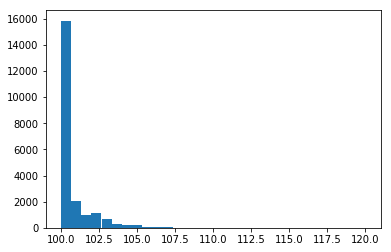

In [59]:
plt.hist(ltv_train, bins=30, range=(100,120))
plt.show()

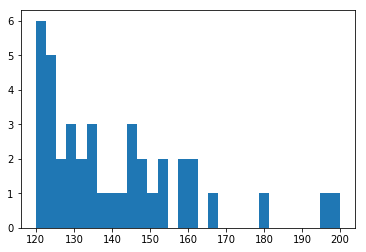

In [60]:
plt.hist(ltv_train, bins=30, range=(120,200))
plt.show()

In [61]:
test.head()

C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62
131497,185000,96.5,1,0,195000,129,0,nan,1,1,0,1,0,0,0,1,0,1,0,nan,nan
851117,365000,95,0,85,385000,121,0,nan,1,1,0,1,0,0,0,0,1,1,0,nan,nan
835616,265000,96.28,1,0,265000,106,0,49,1,1,0,0,1,0,0,0,1,nan,nan,0,1
121491,145000,56.91,1,0,255000,68,0,38,0,1,0,0,1,0,0,0,1,1,0,1,0
4.47964e+06,355000,95,1,0,375000,154,0,46,1,1,0,0,1,0,0,0,1,nan,nan,0,1
843194,365000,96.5,1,0,375000,51,1,nan,1,1,0,1,0,0,0,nan,nan,nan,nan,0,1
6.37726e+06,195000,96.5,1,0,205000,54,0,nan,1,1,0,0,1,0,0,0,1,0,1,nan,nan
5.25537e+06,135000,80,1,0,165000,81,0,48,1,1,0,0,1,0,0,1,0,0,1,nan,nan
4.59782e+06,455000,68.76,0,120,655000,82,0,41,1,1,0,1,0,0,0,0,1,1,0,nan,nan
6.13819e+06,325000,80,1,0,405000,65,0,49,1,1,0,0,1,0,0,0,1,nan,nan,1,0


In [62]:
test.summary()

,C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62
type,int,int,real,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int
mins,4056.0,5000.0,1.0,0.0,0.0,25000.0,0.0,0.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,3323235.642428521,292912.6115677475,88.56029290647881,0.9412283798093893,5.4916040542584845,360743.028591599,182.90381221320155,0.09752407846301246,42.49417061611374,0.9601885936160557,0.9262014018455953,0.07671265111627497,0.08197782157249169,0.8342206665293996,0.004294496573227049,0.0027943642086066416,0.12101442886949366,0.8789855711305063,0.6133134578655611,0.3866865421344389,0.22066733067729083,0.7793326693227092
maxs,6504997.0,4625000.0,79474.0,1.0,360.0,9245000.0,396000.0,1.0,49.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
sigma,1954622.387112297,224087.83385259155,398.9005406950037,0.2351997270603876,24.4766458606141,321800.2616685691,3600.6695096928024,0.29667381367158185,3.970841892486282,0.19551834219733183,0.2614461483363615,0.2661388804577039,0.27433496324350387,0.3718879052734942,0.06539250456663769,0.05278861339759911,0.3261488353928688,0.3261488353928688,0.487002164716498,0.487002164716498,0.4147069141947798,0.4147069141947798
zeros,0,0,0,2331,37331,0,231,35794,0,1579,2927,31389,31210,5636,33851,33902,29911,4118,8301,13166,15649,4431
missing,0,0,0,0,0,0,0,0,18562,0,0,5665,5665,5665,5665,5665,5633,5633,18195,18195,19582,19582
0,131497.0,185000.0,96.5,1.0,0.0,195000.0,129.0,0.0,nan,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,nan,nan
1,851117.0,365000.0,95.0,0.0,85.0,385000.0,121.0,0.0,nan,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,nan,nan
2,835616.0,265000.0,96.28,1.0,0.0,265000.0,106.0,0.0,49.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,nan,nan,0.0,1.0


In [63]:
print(f"Min for test loan_to_value_ratio: {test['loan_to_value_ratio'].min()}")
print(f"Max for test loan_to_value_ratio: {test['loan_to_value_ratio'].max()}")

Min for test loan_to_value_ratio: 1.0
Max for test loan_to_value_ratio: 79474.0


In [64]:
ltv_test = test['loan_to_value_ratio'].as_data_frame().values

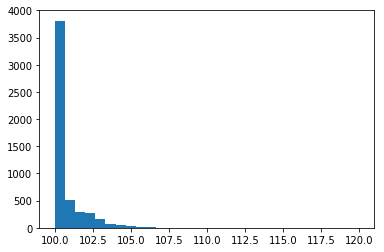

In [65]:
plt.hist(ltv_test, bins=30, range=(100,120))
plt.show()

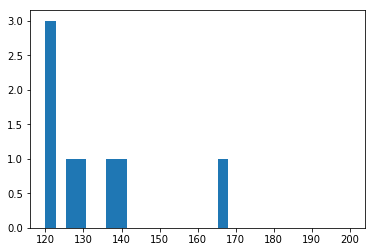

In [66]:
plt.hist(ltv_test, bins=30, range=(120,200))
plt.show()

In [67]:
# Feature Engineering

# Train
# train['loan_amount_conforming'] = (train["conforming"] == 1).ifelse(train['loan_amount'], np.nan)
# train['loan_amount_non_conforming'] = (train["conforming"] == 0).ifelse(train['loan_amount'], np.nan)
train['loan_to_value_ratio_manual'] = train['loan_amount'] / train['property_value'] * 100
train['loan_to_value_ratio_manual'] = train['loan_to_value_ratio_manual'].round()

#Test
# test['loan_amount_conforming'] = (test["conforming"] == 1).ifelse(test['loan_amount'], np.nan)
# test['loan_amount_non_conforming'] = (test["conforming"] == 0).ifelse(test['loan_amount'], np.nan)
test['loan_to_value_ratio_manual'] = test['loan_amount'] / test['property_value'] * 100
test['loan_to_value_ratio_manual'] = test['loan_to_value_ratio_manual'].round()

In [68]:
train.head()

C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,cv_fold,loan_to_value_ratio_manual
2.5493e+06,175000,97,1,0,185000,36,0,47,1,1,nan,nan,nan,nan,nan,nan,nan,1,0,1,0,1,95
4.00076e+06,265000,95,1,0,285000,100,0,nan,1,1,0,0,1,0,0,0,1,nan,nan,1,0,5,93
1.54693e+06,115000,97,0,120,125000,59,0,39,1,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,1,0,5,92
5.45314e+06,275000,57.9,1,0,475000,100,0,nan,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3,58
4.94313e+06,155000,99,1,0,155000,42,0,46,1,1,0,0,1,0,0,1,0,nan,nan,0,1,4,100
1.23729e+06,215000,95,1,0,225000,81,0,42,1,1,0,0,1,0,0,0,1,nan,nan,0,1,3,96
682016,195000,95,1,0,205000,92,0,49,1,1,0,0,1,0,0,0,1,0,1,nan,nan,1,95
19740,125000,100,1,0,125000,38,0,43,1,1,0,0,1,0,0,0,1,1,0,nan,nan,2,100
5.36388e+06,355000,90,1,0,395000,95,0,38,1,1,0,0,1,0,0,0,1,nan,nan,0,1,5,90
1.94229e+06,595000,80,1,0,745000,371,0,nan,1,0,0,0,1,0,0,0,1,nan,nan,0,1,4,80


In [69]:
test.head()

C1,loan_amount,loan_to_value_ratio,no_intro_rate_period,intro_rate_period,property_value,income,high_priced,debt_to_income_ratio,term_360,conforming,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,agegte62,agelt62,loan_to_value_ratio_manual
131497,185000,96.5,1,0,195000,129,0,nan,1,1,0,1,0,0,0,1,0,1,0,nan,nan,95
851117,365000,95,0,85,385000,121,0,nan,1,1,0,1,0,0,0,0,1,1,0,nan,nan,95
835616,265000,96.28,1,0,265000,106,0,49,1,1,0,0,1,0,0,0,1,nan,nan,0,1,100
121491,145000,56.91,1,0,255000,68,0,38,0,1,0,0,1,0,0,0,1,1,0,1,0,57
4.47964e+06,355000,95,1,0,375000,154,0,46,1,1,0,0,1,0,0,0,1,nan,nan,0,1,95
843194,365000,96.5,1,0,375000,51,1,nan,1,1,0,1,0,0,0,nan,nan,nan,nan,0,1,97
6.37726e+06,195000,96.5,1,0,205000,54,0,nan,1,1,0,0,1,0,0,0,1,0,1,nan,nan,95
5.25537e+06,135000,80,1,0,165000,81,0,48,1,1,0,0,1,0,0,1,0,0,1,nan,nan,82
4.59782e+06,455000,68.76,0,120,655000,82,0,41,1,1,0,1,0,0,0,0,1,1,0,nan,nan,69
6.13819e+06,325000,80,1,0,405000,65,0,49,1,1,0,0,1,0,0,0,1,nan,nan,1,0,80


In [70]:
# Inputs and output
X = ['loan_amount', 'loan_to_value_ratio_manual', 'no_intro_rate_period', 'intro_rate_period',
    'property_value', 'income', "debt_to_income_ratio", "term_360", "conforming"]
fold_column = 'cv_fold'
Y = "high_priced"

In [71]:
# Convert outcome to categorical
train[Y] = train[Y].asfactor()
test[Y] = test[Y].asfactor()

In [72]:
# Distribution of outcome in train
train[Y].table()

high_priced,Count
0,144833
1,15505


In [73]:
# Distribution of outcome in test
test[Y].table()

high_priced,Count
0,35794
1,3868


In [74]:
# Function to get Shapley contribs
def get_shapley(model, train, X):
    # calculate SHAP values using function predict_contributions
    contributions = model.predict_contributions(train[X])
    print("First 5 rows of contributions:\n")
    print(contributions.head(5))
    # convert the H2O Frame to use with shap's visualization functions
    contributions_matrix = contributions.as_data_frame().as_matrix()
    # shap values are calculated for all features
    shap_values = contributions_matrix[:,0:len(X)]
    # expected values is the last returned column
    expected_value = contributions_matrix[:,len(X)-1].min()
    return shap_values, expected_value

In [75]:
# Create Pandas frame for correlation purposes
train_pd_for_corr = train.as_data_frame()

In [76]:
# Get correlation
numeric_corr = pd.DataFrame(train_pd_for_corr[X + [Y]].corr()[Y]).iloc[:-1]
numeric_corr

,high_priced
loan_amount,-0.123545
loan_to_value_ratio_manual,0.111645
no_intro_rate_period,0.018108
intro_rate_period,-0.031716
property_value,-0.137319
income,-0.007911
debt_to_income_ratio,0.031007
term_360,0.052448
conforming,0.074543


In [77]:
# Filter to correlations > 0.1
numeric_corr = numeric_corr[numeric_corr['high_priced'].abs() > 0.1]
numeric_corr

,high_priced
loan_amount,-0.123545
loan_to_value_ratio_manual,0.111645
property_value,-0.137319


In [78]:
# Apply monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train_pd_for_corr[list(numeric_corr.index) + [Y]].corr()[Y].values[:-1])])
mono_constraints = dict(zip(list(numeric_corr.index.tolist()), mono_constraints))
#del mono_constraints['loan_amount_conforming']
#del mono_constraints['property_value']
mono_constraints

{'loan_amount': -1, 'loan_to_value_ratio_manual': 1, 'property_value': -1}

In [79]:
# Default GBM with monotonic constraints
mgbm_default = H2OGradientBoostingEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED,
               categorical_encoding="one_hot_explicit")
mgbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [80]:
mgbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1575671949109_358


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,16363.0,5.0,5.0,5.0,13.0,29.0,21.44




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07936307378510005
RMSE: 0.28171452533566677
LogLoss: 0.267718020502024
Mean Per-Class Error: 0.2637873410333461
AUC: 0.7882459648680366
pr_auc: 0.2358041527367917
Gini: 0.5764919297360731

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1378551624676984: 


,,0,1,Error,Rate
0,0,103930.0,40903.0,0.2824,(40903.0/144833.0)
1,1,4504.0,11001.0,0.2905,(4504.0/15505.0)
2,Total,108434.0,51904.0,0.2832,(45407.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.137855,0.326396,220.0
1,max f2,0.099413,0.507747,260.0
2,max f0point5,0.206674,0.264221,157.0
3,max accuracy,0.902245,0.903304,0.0
4,max precision,0.902245,1.000000,0.0
5,max recall,0.004658,1.000000,398.0
6,max specificity,0.902245,1.000000,0.0
7,max absolute_mcc,0.109775,0.284841,250.0
8,max min_per_class_accuracy,0.136409,0.713705,222.0
9,max mean_per_class_accuracy,0.099413,0.736213,260.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.66 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010010,0.385481,3.717624,3.717624,0.359502,0.445226,0.359502,0.445226,0.037214,0.037214,271.762404,271.762404
1,,2,0.020351,0.333355,2.925183,3.314968,0.282871,0.356076,0.320564,0.399927,0.030248,0.067462,192.518278,231.496771
2,,3,0.032182,0.276147,2.834658,3.138389,0.274117,0.291903,0.303488,0.360214,0.033538,0.101000,183.465823,213.838882
3,,4,0.040770,0.271269,2.568366,3.018315,0.248366,0.273000,0.291877,0.341842,0.022057,0.123057,156.836568,201.831510
4,,5,0.050269,0.263223,2.600540,2.939373,0.251477,0.266863,0.284243,0.327674,0.024702,0.147759,160.054014,193.937326
5,,6,0.100513,0.216782,2.460749,2.700121,0.237959,0.232973,0.261107,0.280335,0.123638,0.271396,146.074917,170.012061
6,,7,0.150283,0.197350,2.155034,2.519601,0.208396,0.205870,0.243650,0.255674,0.107256,0.378652,115.503362,151.960126
7,,8,0.200495,0.179086,2.069238,2.406811,0.200099,0.190964,0.232743,0.239468,0.103902,0.482554,106.923781,140.681076
8,,9,0.300908,0.149490,1.858178,2.223732,0.179689,0.165061,0.215039,0.214638,0.186585,0.669139,85.817772,122.373219
9,,10,0.400454,0.103335,1.576976,2.062960,0.152497,0.125785,0.199492,0.192551,0.156982,0.826121,57.697630,106.295985




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.079574160845875
RMSE: 0.2820889236497509
LogLoss: 0.26843071924733786
Mean Per-Class Error: 0.26606240309244455
AUC: 0.7861960101172512
pr_auc: 0.23211324737618383
Gini: 0.5723920202345023

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13985867600294397: 


,,0,1,Error,Rate
0,0,104324.0,40509.0,0.2797,(40509.0/144833.0)
1,1,4632.0,10873.0,0.2987,(4632.0/15505.0)
2,Total,108956.0,51382.0,0.2815,(45141.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.139859,0.325115,227.0
1,max f2,0.104143,0.505578,261.0
2,max f0point5,0.212256,0.260799,154.0
3,max accuracy,0.903135,0.903292,0.0
4,max precision,0.395459,0.344402,59.0
5,max recall,0.004248,1.000000,399.0
6,max specificity,0.903135,0.999993,0.0
7,max absolute_mcc,0.109523,0.282626,256.0
8,max min_per_class_accuracy,0.137585,0.712286,229.0
9,max mean_per_class_accuracy,0.102201,0.733938,263.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.65 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010029,0.382048,3.537051,3.537051,0.342040,0.448075,0.342040,0.448075,0.035472,0.035472,253.705112,253.705112
1,,2,0.020001,0.335244,3.052518,3.295464,0.295184,0.356290,0.318678,0.402311,0.030442,0.065914,205.251795,229.546442
2,,3,0.030099,0.283996,2.708218,3.098458,0.261890,0.302660,0.299627,0.368881,0.027346,0.093260,170.821849,209.845838
3,,4,0.040003,0.269878,2.630847,2.982686,0.254408,0.274896,0.288432,0.345611,0.026056,0.119316,163.084680,198.268551
4,,5,0.050057,0.259934,2.604508,2.906730,0.251861,0.264749,0.281086,0.329371,0.026185,0.145501,160.450795,190.672959
5,,6,0.100351,0.215423,2.415990,2.660780,0.233631,0.232646,0.257303,0.280894,0.121509,0.267011,141.598966,166.078013
6,,7,0.150033,0.198290,2.147138,2.490691,0.207632,0.206814,0.240855,0.256363,0.106675,0.373686,114.713769,149.069052
7,,8,0.200370,0.178949,2.094860,2.391249,0.202577,0.190068,0.231239,0.239708,0.105450,0.479136,109.486047,139.124941
8,,9,0.300004,0.150115,1.877249,2.220546,0.181534,0.165438,0.214731,0.215043,0.187036,0.666172,87.724874,122.054631
9,,10,0.400585,0.101520,1.564591,2.055845,0.151299,0.127169,0.198804,0.192979,0.157369,0.823541,56.459138,105.584524




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.7126713,0.02059379,0.7150228,0.72174734,0.73762715,0.6817548,0.7072043
1,auc,0.7863806,0.004430725,0.7827704,0.79305243,0.7843272,0.7887272,0.78302574
2,err,0.28732872,0.02059379,0.28497717,0.27825266,0.26237285,0.3182452,0.29279572
3,err_count,9216.0,699.41797,9113.0,8854.0,8408.0,10272.0,9433.0
4,f0point5,0.24622838,0.007579009,0.2443197,0.25793335,0.24622382,0.23679505,0.24586995
5,f1,0.3266421,0.0072530597,0.32411185,0.33905643,0.32149774,0.32180113,0.32674327
6,f2,0.48557937,0.014824702,0.48129874,0.49462038,0.463062,0.5020188,0.48689696
7,lift_top_group,3.5412655,0.1724855,3.699764,3.437712,3.7120733,3.5477679,3.3090105
8,logloss,0.26844022,0.004176846,0.2688608,0.27229565,0.26582062,0.26278973,0.2724343
9,max_per_class_error,0.3091764,0.026535086,0.28873697,0.28741762,0.34452122,0.3306653,0.29454082



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-06 14:45:34,13.398 sec,0.0,0.295552,0.317775,0.500000,0.000000,1.000000,0.903298
1,,2019-12-06 14:45:34,13.433 sec,1.0,0.293248,0.310204,0.766089,0.220515,3.471004,0.267591
2,,2019-12-06 14:45:34,13.458 sec,2.0,0.291476,0.304630,0.768192,0.222153,3.471004,0.286114
3,,2019-12-06 14:45:34,13.482 sec,3.0,0.290069,0.300273,0.767182,0.227270,3.471004,0.276572
4,,2019-12-06 14:45:34,13.505 sec,4.0,0.288948,0.296797,0.766859,0.227900,3.469419,0.289345
5,,2019-12-06 14:45:34,13.529 sec,5.0,0.288022,0.293901,0.766249,0.227831,3.853808,0.304806
6,,2019-12-06 14:45:34,13.552 sec,6.0,0.287155,0.291094,0.768896,0.228176,3.853808,0.266917
7,,2019-12-06 14:45:34,13.579 sec,7.0,0.286507,0.288998,0.768566,0.229131,3.853808,0.264373
8,,2019-12-06 14:45:34,13.606 sec,8.0,0.285910,0.286946,0.770004,0.230430,3.851416,0.261784
9,,2019-12-06 14:45:34,13.638 sec,9.0,0.285465,0.285484,0.769602,0.230295,3.851416,0.261791



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_manual,3876.424805,1.000000,0.538027
1,property_value,1591.608032,0.410587,0.220907
2,intro_rate_period,603.363403,0.155649,0.083744
3,loan_amount,582.409668,0.150244,0.080835
4,debt_to_income_ratio,279.039215,0.071984,0.038729
5,no_intro_rate_period,142.634735,0.036795,0.019797
6,term_360,84.113129,0.021699,0.011674
7,income,32.075806,0.008275,0.004452
8,conforming,13.224936,0.003412,0.001836


In [81]:
# Get the AUC on the test set for MGBM
perf_mgbm_default = mgbm_default.model_performance(test)
print(perf_mgbm_default.auc())

0.7885528822315954


In [82]:
# Get the AUC on 5 fold CV for MGBM
perf_cv_mgbm_default = mgbm_default.model_performance(xval=True)
print(perf_cv_mgbm_default.auc())

0.7861960101172512


In [83]:
# Default GBM
gbm_default = H2OGradientBoostingEstimator(
               seed=SEED,
               categorical_encoding="one_hot_explicit")
gbm_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [84]:
gbm_default

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1575671949109_877


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,21329.0,5.0,5.0,5.0,19.0,32.0,29.34




ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.07700004552132211
RMSE: 0.2774888205339489
LogLoss: 0.25736203772852667
Mean Per-Class Error: 0.2418535147819716
AUC: 0.8098533274319011
pr_auc: 0.277226363672246
Gini: 0.6197066548638022

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1654405448670356: 


,,0,1,Error,Rate
0,0,103831.0,41002.0,0.2831,(41002.0/144833.0)
1,1,3569.0,11936.0,0.2302,(3569.0/15505.0)
2,Total,107400.0,52938.0,0.278,(44571.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.165441,0.348787,217.0
1,max f2,0.106340,0.533107,256.0
2,max f0point5,0.216811,0.285188,156.0
3,max accuracy,0.404119,0.904159,46.0
4,max precision,0.704385,1.000000,0.0
5,max recall,0.005366,1.000000,399.0
6,max specificity,0.704385,1.000000,0.0
7,max absolute_mcc,0.138571,0.313475,239.0
8,max min_per_class_accuracy,0.171201,0.733514,210.0
9,max mean_per_class_accuracy,0.099070,0.758146,261.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.68 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010016,0.321323,5.022428,5.022428,0.485679,0.394856,0.485679,0.394856,0.050306,0.050306,402.242839,402.242839
1,,2,0.020001,0.285176,2.984113,4.004860,0.288570,0.305582,0.387278,0.350289,0.029797,0.080103,198.411348,300.485989
2,,3,0.031733,0.270206,3.183131,3.701072,0.307815,0.275288,0.357901,0.322562,0.037343,0.117446,218.313062,270.107201
3,,4,0.040159,0.264242,3.038784,3.562114,0.293856,0.266633,0.344463,0.310827,0.025605,0.143051,203.878413,256.211395
4,,5,0.050144,0.260268,2.693453,3.389138,0.260462,0.261940,0.327736,0.301092,0.026895,0.169945,169.345308,238.913807
5,,6,0.100126,0.230078,2.411708,2.901214,0.233217,0.246557,0.280553,0.273869,0.120542,0.290487,141.170762,190.121434
6,,7,0.150769,0.210024,2.370037,2.722793,0.229187,0.217399,0.263299,0.254901,0.120026,0.410513,137.003650,172.279273
7,,8,0.202329,0.198119,2.169031,2.581677,0.209750,0.203608,0.249653,0.241830,0.111835,0.522348,116.903144,158.167671
8,,9,0.300004,0.176448,1.972334,2.383287,0.190729,0.187690,0.230469,0.224203,0.192648,0.714995,97.233383,138.328748
9,,10,0.400042,0.088257,1.506028,2.163911,0.145636,0.150123,0.209254,0.205678,0.150661,0.865656,50.602841,116.391117




ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.07745945126046966
RMSE: 0.27831538092687164
LogLoss: 0.25933031669445206
Mean Per-Class Error: 0.24487959069709553
AUC: 0.8056296304859408
pr_auc: 0.263765793463033
Gini: 0.6112592609718817

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1703108450125317: 


,,0,1,Error,Rate
0,0,105843.0,38990.0,0.2692,(38990.0/144833.0)
1,1,4086.0,11419.0,0.2635,(4086.0/15505.0)
2,Total,109929.0,50409.0,0.2687,(43076.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.170311,0.346482,214.0
1,max f2,0.115682,0.529887,259.0
2,max f0point5,0.219007,0.282169,152.0
3,max accuracy,0.467527,0.903654,31.0
4,max precision,0.566569,0.772152,16.0
5,max recall,0.005321,1.000000,399.0
6,max specificity,0.816873,0.999993,0.0
7,max absolute_mcc,0.141367,0.310348,243.0
8,max min_per_class_accuracy,0.171267,0.730861,213.0
9,max mean_per_class_accuracy,0.111797,0.755120,261.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.68 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010048,0.326132,4.409871,4.409871,0.426443,0.393468,0.426443,0.393468,0.044308,0.044308,340.987103,340.987103
1,,2,0.020014,0.293520,3.022072,3.718783,0.292240,0.308176,0.359614,0.350995,0.030119,0.074428,202.207193,271.878254
2,,3,0.030055,0.276519,3.044508,3.493511,0.294410,0.284142,0.337829,0.328660,0.030571,0.104998,204.450826,249.351141
3,,4,0.040003,0.267694,3.066657,3.387363,0.296552,0.272131,0.327565,0.314602,0.030506,0.135505,206.665658,238.736338
4,,5,0.050013,0.260001,2.686740,3.247134,0.259813,0.263316,0.314004,0.304337,0.026895,0.162399,168.674042,224.713395
5,,6,0.100001,0.229124,2.490110,2.868716,0.240799,0.244760,0.277411,0.274556,0.124476,0.286875,149.010966,186.871623
6,,7,0.150002,0.210050,2.341151,2.692861,0.226394,0.217266,0.260405,0.255460,0.117059,0.403934,134.115106,169.286118
7,,8,0.200009,0.199399,2.100969,2.544874,0.203168,0.204802,0.246094,0.242794,0.105063,0.508997,110.096938,154.487439
8,,9,0.300041,0.174457,1.989680,2.359775,0.192406,0.187287,0.228195,0.224288,0.199033,0.708030,98.968042,135.977511
9,,10,0.400005,0.088613,1.520705,2.150086,0.147055,0.148968,0.207918,0.205465,0.152015,0.860045,52.070488,115.008605




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.72242534,0.008575278,0.72049534,0.7281898,0.722243,0.7317904,0.7094081
1,auc,0.80586064,0.0039900145,0.8049971,0.8112206,0.8014629,0.8085372,0.80308545
2,err,0.27757466,0.008575278,0.27950466,0.27181017,0.277757,0.26820955,0.29059193
3,err_count,8901.4,290.22803,8938.0,8649.0,8901.0,8657.0,9362.0
4,f0point5,0.2618063,0.007176713,0.25924048,0.27381888,0.25461462,0.26001832,0.26133928
5,f1,0.34740922,0.0083621675,0.3447214,0.36070663,0.3383632,0.344117,0.34913793
6,f2,0.51625633,0.010541623,0.51430696,0.5283673,0.5042091,0.50862265,0.5257758
7,lift_top_group,4.4710054,0.19209674,4.6194158,4.49294,4.1461434,4.486519,4.6100087
8,logloss,0.25934032,0.0041542244,0.25883046,0.26334783,0.25801063,0.25332722,0.2631854
9,max_per_class_error,0.28205562,0.011273235,0.28426623,0.2759753,0.28055298,0.26974517,0.2997384



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-06 14:46:14,12.498 sec,0.0,0.295552,0.317775,0.500000,0.000000,1.000000,0.903298
1,,2019-12-06 14:46:14,12.528 sec,1.0,0.292619,0.308183,0.788923,0.237853,3.625370,0.339714
2,,2019-12-06 14:46:14,12.548 sec,2.0,0.290216,0.300653,0.792216,0.241450,3.704893,0.277794
3,,2019-12-06 14:46:14,12.568 sec,3.0,0.288306,0.294740,0.793347,0.242239,3.704893,0.279653
4,,2019-12-06 14:46:14,12.589 sec,4.0,0.286710,0.289813,0.794771,0.248768,4.316959,0.275300
5,,2019-12-06 14:46:14,12.609 sec,5.0,0.285331,0.285539,0.797257,0.250120,4.316959,0.321458
6,,2019-12-06 14:46:14,12.631 sec,6.0,0.284249,0.282079,0.797431,0.251182,4.301406,0.322151
7,,2019-12-06 14:46:14,12.652 sec,7.0,0.283313,0.279060,0.798212,0.252481,4.254375,0.320598
8,,2019-12-06 14:46:14,12.675 sec,8.0,0.282540,0.276492,0.798783,0.253019,4.290624,0.271508
9,,2019-12-06 14:46:14,12.696 sec,9.0,0.281922,0.274396,0.799572,0.254227,4.271304,0.294790



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_manual,4922.352539,1.000000,0.583300
1,property_value,1999.412598,0.406190,0.236931
2,intro_rate_period,614.811890,0.124902,0.072855
3,debt_to_income_ratio,285.597290,0.058020,0.033843
4,loan_amount,219.039841,0.044499,0.025956
5,no_intro_rate_period,186.743530,0.037938,0.022129
6,income,108.403984,0.022023,0.012846
7,term_360,66.524773,0.013515,0.007883
8,conforming,35.916443,0.007297,0.004256


In [85]:
# Get the AUC on the test set for the default GBM
perf_gbm_default = gbm_default.model_performance(test)
print(perf_gbm_default.auc())

0.8075172440552191


In [86]:
# Get the AUC on 5 fold CV for the default GBM
perf_cv_gbm_default = gbm_default.model_performance(xval=True)
print(perf_cv_gbm_default.auc())

0.8056296304859408


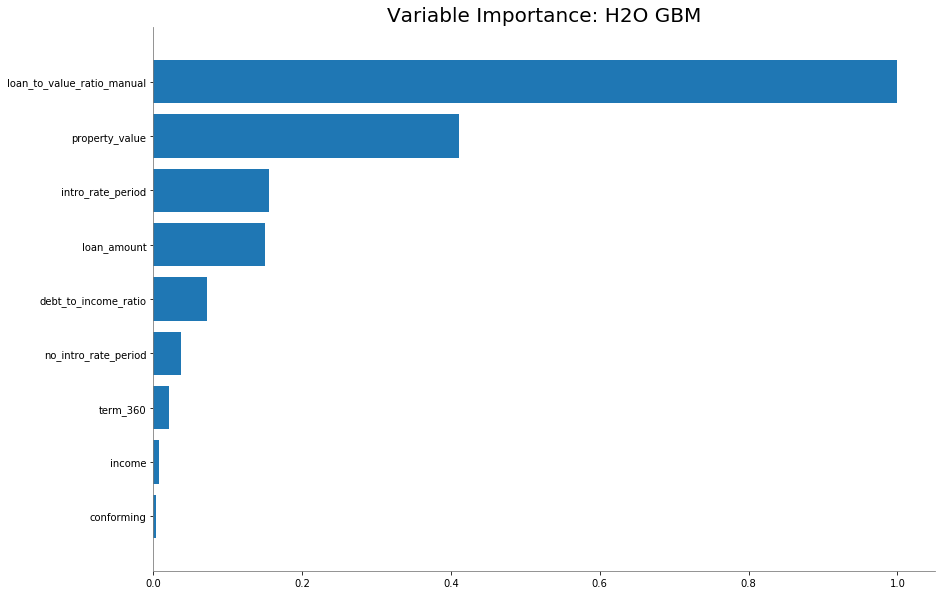

In [87]:
# MGBM var importance
mgbm_default.varimp_plot()

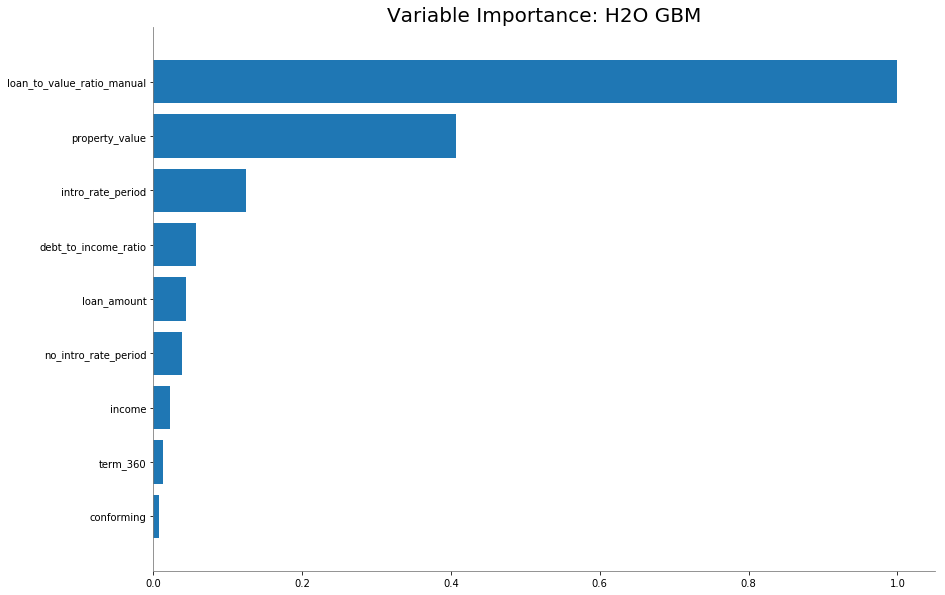

In [88]:
# GBM var importance
gbm_default.varimp_plot()

## Shapley for MGBM

In [89]:
shap_values_mgbm_default, expected_value_mgbm_default = get_shapley(mgbm_default, train, X)

First 5 rows of contributions:



loan_amount,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_to_value_ratio_manual,BiasTerm
0.0689908,-0.00692373,0.00636902,0.35792,-0.00472599,0.20542,0.0225917,0.00901557,1.07938,-2.81638
-0.0450666,-0.00234213,0.00723348,-0.112557,0.00132095,-0.0853564,0.0283993,0.0119366,0.567858,-2.81638
0.110924,-0.195525,-0.685177,0.610828,-0.00424011,-0.0480617,0.0177953,0.0109837,0.554466,-2.81638
-0.0346702,-0.0115353,-0.00477665,-0.405752,0.00149307,-0.0530163,0.0384195,0.0382031,-1.18198,-2.81638
0.0653105,-0.00466158,0.00693673,0.434449,-0.00333001,0.19301,0.0222446,0.00841027,1.0728,-2.81638


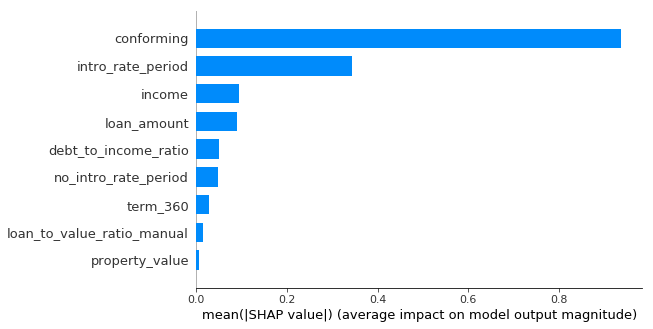

In [90]:
shap.summary_plot(shap_values_mgbm_default, X, plot_type="bar")

## Shapley for GBM

In [91]:
shap_values_gbm_default, expected_value_gbm_default = get_shapley(gbm_default, train, X)

First 5 rows of contributions:



loan_amount,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_to_value_ratio_manual,BiasTerm
0.0238087,-0.00426381,0.00642767,0.480612,-0.0510216,0.164062,0.0224771,0.00247379,1.19543,-2.98225
0.0241445,-0.0151249,0.00691952,-0.310993,0.00902162,-0.151289,0.0229082,0.00196465,0.501803,-2.98225
0.0704652,-0.579993,-0.139178,0.926834,-0.0183371,0.156715,0.00928528,0.00399389,0.467166,-2.98225
0.0133984,-0.124445,-0.0119325,-0.515417,0.00701867,-0.0556454,0.0153296,0.0033256,-1.23451,-2.98225
0.0444132,-0.00542352,0.00970737,0.477931,0.00240744,0.159186,0.0169258,0.00247379,1.19416,-2.98225


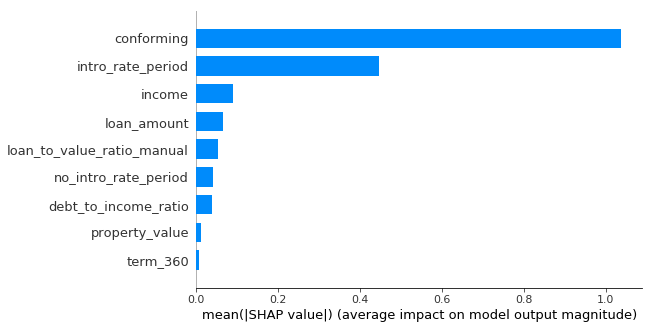

In [92]:
shap.summary_plot(shap_values_gbm_default, X, plot_type="bar")

In [93]:
# Default XGBoost with monotonic constraints
mxgb_default = H2OXGBoostEstimator(
               # monotonicity constraints
               monotone_constraints=mono_constraints, 
               seed=SEED)
mxgb_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [94]:
mxgb_default

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1575671949109_1416


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07834113863228682
RMSE: 0.27989487067877256
LogLoss: 0.26329167964277106
Mean Per-Class Error: 0.26353478225507254
AUC: 0.7967656166967761
pr_auc: 0.25711710492328516
Gini: 0.5935312333935523

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16028420957850248: 


,,0,1,Error,Rate
0,0,109234.0,35599.0,0.2458,(35599.0/144833.0)
1,1,5217.0,10288.0,0.3365,(5217.0/15505.0)
2,Total,114451.0,45887.0,0.2546,(40816.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.160284,0.335158,211.0
1,max f2,0.100643,0.507743,268.0
2,max f0point5,0.215778,0.280942,153.0
3,max accuracy,0.553797,0.903504,22.0
4,max precision,0.662098,0.724138,11.0
5,max recall,0.000823,1.000000,398.0
6,max specificity,0.851661,0.999993,0.0
7,max absolute_mcc,0.116301,0.285327,253.0
8,max min_per_class_accuracy,0.144908,0.720692,226.0
9,max mean_per_class_accuracy,0.100643,0.736465,268.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.63 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010104,0.351345,4.468355,4.468355,0.432099,0.431892,0.432099,0.431892,0.045147,0.045147,346.835549,346.835549
1,,2,0.020014,0.306953,2.987126,3.734895,0.288861,0.325241,0.361172,0.379081,0.029603,0.074750,198.712557,273.489512
2,,3,0.030024,0.287528,2.976676,3.482103,0.287850,0.295634,0.336726,0.351260,0.029797,0.104547,197.667644,248.210306
3,,4,0.040003,0.273023,2.985979,3.358343,0.288750,0.279995,0.324758,0.333483,0.029797,0.134344,198.597856,235.834266
4,,5,0.050125,0.262525,2.822604,3.250155,0.272951,0.267537,0.314296,0.320166,0.028571,0.162915,182.260364,225.015497
5,,6,0.100114,0.220359,2.490110,2.870653,0.240799,0.238948,0.277598,0.279612,0.124476,0.287391,149.010966,187.065316
6,,7,0.150021,0.203144,2.230524,2.657703,0.215696,0.210445,0.257005,0.256603,0.111319,0.398710,123.052418,165.770263
7,,8,0.200090,0.191117,2.055844,2.507097,0.198804,0.197842,0.242441,0.241899,0.102935,0.501645,105.584427,150.709734
8,,9,0.300060,0.153148,1.843828,2.286118,0.178302,0.172612,0.221072,0.218815,0.184328,0.685972,84.382834,128.611796
9,,10,0.400111,0.109134,1.396255,2.063600,0.135021,0.131235,0.199554,0.196915,0.139697,0.825669,39.625465,106.360012




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.07940197873425209
RMSE: 0.28178356718277964
LogLoss: 0.26800264460925155
Mean Per-Class Error: 0.2704648603361044
AUC: 0.7869357607927019
pr_auc: 0.2359141529202797
Gini: 0.5738715215854038

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.14488905433813734: 


,,0,1,Error,Rate
0,0,104587.0,40246.0,0.2779,(40246.0/144833.0)
1,1,4572.0,10933.0,0.2949,(4572.0/15505.0)
2,Total,109159.0,51179.0,0.2795,(44818.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.144889,0.327905,233.0
1,max f2,0.101428,0.500391,275.0
2,max f0point5,0.210808,0.266108,165.0
3,max accuracy,0.916054,0.903292,0.0
4,max precision,0.397606,0.357965,57.0
5,max recall,0.000420,1.000000,399.0
6,max specificity,0.916054,0.999993,0.0
7,max absolute_mcc,0.118996,0.276826,258.0
8,max min_per_class_accuracy,0.142117,0.715424,236.0
9,max mean_per_class_accuracy,0.101428,0.729535,275.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.60 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.356615,3.597448,3.597448,0.347880,0.439461,0.347880,0.439461,0.035988,0.035988,259.744801,259.744801
1,,2,0.020001,0.315425,2.896527,3.247097,0.280100,0.332174,0.314001,0.385834,0.028958,0.064947,189.652653,224.709655
2,,3,0.030024,0.295346,2.921492,3.138404,0.282514,0.304646,0.303490,0.358732,0.029281,0.094228,192.149177,213.840380
3,,4,0.040009,0.277967,2.900145,3.078941,0.280450,0.286142,0.297740,0.340616,0.028958,0.123186,190.014492,207.894122
4,,5,0.050001,0.266634,2.698227,3.002865,0.260924,0.272193,0.290383,0.326943,0.026959,0.150145,169.822686,200.286483
5,,6,0.100020,0.225007,2.418929,2.710842,0.233915,0.243391,0.262144,0.285159,0.120993,0.271138,141.892920,171.084240
6,,7,0.150002,0.203759,2.201377,2.541084,0.212877,0.213269,0.245728,0.261205,0.110029,0.381167,120.137677,154.108407
7,,8,0.200002,0.189371,2.043186,2.416610,0.197580,0.197257,0.233691,0.245218,0.102161,0.483328,104.318638,141.660965
8,,9,0.300010,0.151058,1.888927,2.240708,0.182663,0.171117,0.216681,0.220517,0.188907,0.672235,88.892667,124.070801
9,,10,0.399999,0.106042,1.411961,2.033544,0.136539,0.129659,0.196648,0.197805,0.141180,0.813415,41.196116,103.354391




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.72348326,0.0074088094,0.72606164,0.72614706,0.7327592,0.71354216,0.71890616
1,auc,0.78703445,0.003878272,0.78398156,0.79237866,0.7866017,0.78929645,0.7829138
2,err,0.27651677,0.0074088094,0.27393833,0.2738529,0.26724085,0.28645784,0.28109384
3,err_count,8868.0,276.59717,8760.0,8714.0,8564.0,9246.0,9056.0
4,f0point5,0.24934587,0.006335622,0.24712025,0.25998014,0.24741054,0.2431241,0.2490943
5,f1,0.32863823,0.00696753,0.32521954,0.34074748,0.3247122,0.32412282,0.3283892
6,f2,0.48197562,0.008734933,0.47549328,0.49431494,0.47226936,0.4860563,0.4817442
7,lift_top_group,3.6128578,0.1888782,3.513208,3.6932561,3.9091744,3.4820683,3.4665825
8,logloss,0.26801187,0.0046790903,0.26881295,0.27193457,0.26435632,0.2621106,0.27284488
9,max_per_class_error,0.30343968,0.014119274,0.31282553,0.29337937,0.3224745,0.28804514,0.30047393



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-06 14:46:51,23.307 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.903298
1,,2019-12-06 14:46:51,23.486 sec,1.0,0.405575,0.518457,0.774159,0.229673,3.477448,0.270073
2,,2019-12-06 14:46:51,23.546 sec,2.0,0.351353,0.424938,0.774929,0.234576,3.795636,0.260250
3,,2019-12-06 14:46:51,23.594 sec,3.0,0.320099,0.368783,0.777007,0.236601,3.815777,0.267080
4,,2019-12-06 14:46:51,23.643 sec,4.0,0.302651,0.333766,0.777338,0.237911,3.876331,0.268520
5,,2019-12-06 14:46:51,23.692 sec,5.0,0.293050,0.311322,0.779767,0.238731,3.872340,0.270348
6,,2019-12-06 14:46:51,23.743 sec,6.0,0.287834,0.296712,0.780499,0.239443,3.926247,0.285210
7,,2019-12-06 14:46:51,23.802 sec,7.0,0.285005,0.287092,0.781009,0.239478,3.885332,0.291253
8,,2019-12-06 14:46:51,23.859 sec,8.0,0.283495,0.280768,0.781454,0.239700,3.896203,0.276310
9,,2019-12-06 14:46:51,23.917 sec,9.0,0.282693,0.276662,0.781433,0.240370,3.938845,0.273273



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_manual,17382.439453,1.000000,0.588391
1,property_value,4595.937988,0.264401,0.155571
2,loan_amount,2464.624268,0.141788,0.083427
3,income,1474.101074,0.084804,0.049898
4,debt_to_income_ratio,1230.254517,0.070776,0.041644
5,intro_rate_period,1109.124878,0.063807,0.037544
6,no_intro_rate_period,996.219177,0.057312,0.033722
7,term_360,194.187271,0.011171,0.006573
8,conforming,95.455353,0.005491,0.003231


In [95]:
# Get the AUC on the test set for MXGB
perf_mxgb_default = mxgb_default.model_performance(test)
print(perf_mxgb_default.auc())

0.7910492493267952


In [96]:
# Get the AUC on 5 fold CV for the default MXGB
perf_cv_mxgb_default = mxgb_default.model_performance(xval=True)
print(perf_cv_mxgb_default.auc())

0.7869357607927019


In [97]:
# Default XGBoost
xgb_default = H2OXGBoostEstimator(
               seed=SEED)
xgb_default.train(x=X,
              y=Y,
              training_frame=train,
              fold_column=fold_column)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [98]:
xgb_default

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1575671949109_1782


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.07495464834583394
RMSE: 0.2737784658183217
LogLoss: 0.247892827673959
Mean Per-Class Error: 0.23047428332502906
AUC: 0.8302649682044483
pr_auc: 0.31768573806630995
Gini: 0.6605299364088966

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18673577503516123: 


,,0,1,Error,Rate
0,0,113634.0,31199.0,0.2154,(31199.0/144833.0)
1,1,4905.0,10600.0,0.3163,(4905.0/15505.0)
2,Total,118539.0,41799.0,0.2252,(36104.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.186736,0.369957,204.0
1,max f2,0.121397,0.546904,257.0
2,max f0point5,0.234506,0.318858,155.0
3,max accuracy,0.427195,0.905331,61.0
4,max precision,0.906136,1.000000,0.0
5,max recall,0.002601,1.000000,393.0
6,max specificity,0.906136,1.000000,0.0
7,max absolute_mcc,0.137530,0.330264,245.0
8,max min_per_class_accuracy,0.173120,0.750264,216.0
9,max mean_per_class_accuracy,0.103102,0.769526,270.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.68 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.358954,5.982853,5.982853,0.578554,0.473374,0.578554,0.473374,0.059852,0.059852,498.285261,498.285261
1,,2,0.020001,0.312288,3.560986,4.772297,0.344354,0.331208,0.461490,0.402313,0.035601,0.095453,256.098584,377.229681
2,,3,0.030030,0.296230,3.395569,4.312530,0.328358,0.303781,0.417030,0.369408,0.034054,0.129507,239.556907,331.252979
3,,4,0.040040,0.286077,3.111980,4.012392,0.300935,0.291177,0.388006,0.349850,0.031151,0.160658,211.197992,301.239232
4,,5,0.050412,0.274311,2.835550,3.770268,0.274203,0.279873,0.364592,0.335453,0.029410,0.190068,183.554984,277.026823
5,,6,0.100051,0.234765,2.770087,3.274043,0.267873,0.253511,0.316606,0.294799,0.137504,0.327572,177.008686,227.404310
6,,7,0.150326,0.216707,2.396363,2.980512,0.231733,0.224791,0.288221,0.271385,0.120477,0.448049,139.636320,198.051210
7,,8,0.200021,0.203061,2.212788,2.789772,0.213981,0.209912,0.269776,0.256113,0.109965,0.558014,121.278770,178.977193
8,,9,0.300004,0.171449,1.969386,2.516361,0.190444,0.188814,0.243337,0.233684,0.196904,0.754918,96.938616,151.636117
9,,10,0.400005,0.095368,1.307304,2.214097,0.126419,0.137599,0.214108,0.209663,0.130732,0.885650,30.730391,121.409686




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.07715619762545137
RMSE: 0.2777700445070551
LogLoss: 0.2575455819543876
Mean Per-Class Error: 0.2426362967030986
AUC: 0.8100549124472514
pr_auc: 0.26896389328101084
Gini: 0.6201098248945027

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17174685264931244: 


,,0,1,Error,Rate
0,0,108238.0,36595.0,0.2527,(36595.0/144833.0)
1,1,4332.0,11173.0,0.2794,(4332.0/15505.0)
2,Total,112570.0,47768.0,0.2553,(40927.0/160338.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.171747,0.353168,220.0
1,max f2,0.103559,0.531885,275.0
2,max f0point5,0.224337,0.288035,163.0
3,max accuracy,0.542594,0.903728,37.0
4,max precision,0.930840,1.000000,0.0
5,max recall,0.000585,1.000000,399.0
6,max specificity,0.930840,1.000000,0.0
7,max absolute_mcc,0.120326,0.312196,261.0
8,max min_per_class_accuracy,0.166499,0.737622,225.0
9,max mean_per_class_accuracy,0.099308,0.757364,278.0



Gains/Lift Table: Avg response rate:  9.67 %, avg score:  9.66 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010004,0.354787,4.325963,4.325963,0.418329,0.460825,0.418329,0.460825,0.043276,0.043276,332.596347,332.596347
1,,2,0.020076,0.315937,3.259192,3.790755,0.315170,0.331195,0.366573,0.395789,0.032828,0.076104,225.919201,279.075505
2,,3,0.030037,0.297564,3.049865,3.545074,0.294928,0.305992,0.342816,0.366012,0.030377,0.106482,204.986547,254.507385
3,,4,0.040003,0.285867,2.918532,3.388976,0.282228,0.291587,0.327721,0.347470,0.029087,0.135569,191.853199,238.897564
4,,5,0.050013,0.275174,2.828487,3.276794,0.273520,0.280092,0.316872,0.333984,0.028313,0.163883,182.848692,227.679403
5,,6,0.100001,0.237595,2.593327,2.935146,0.250780,0.254366,0.283834,0.294185,0.129636,0.293518,159.332665,193.514559
6,,7,0.150083,0.214763,2.352815,2.740826,0.227522,0.224868,0.265043,0.271054,0.117833,0.411351,135.281453,174.082551
7,,8,0.200015,0.202923,2.200993,2.606061,0.212840,0.208678,0.252011,0.255483,0.109900,0.521251,120.099318,160.606100
8,,9,0.300047,0.170683,2.025141,2.412389,0.195835,0.188492,0.233283,0.233149,0.202580,0.723831,102.514135,141.238892
9,,10,0.399999,0.096562,1.406037,2.160923,0.135967,0.136526,0.208965,0.209005,0.140535,0.864366,40.603711,116.092257




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.74681544,0.007933363,0.75164175,0.7379007,0.7385009,0.7518047,0.7542291
1,auc,0.81013685,0.0034278391,0.80787116,0.8147668,0.8068419,0.81274,0.80846447
2,err,0.25318456,0.007933363,0.24835825,0.2620993,0.2614991,0.2481953,0.24577087
3,err_count,8118.2,223.80392,7942.0,8340.0,8380.0,8011.0,7918.0
4,f0point5,0.27135107,0.0068651647,0.2705693,0.28003895,0.26285172,0.26717463,0.27612072
5,f1,0.3537232,0.008339861,0.3514617,0.3667426,0.34572142,0.3481162,0.35657403
6,f2,0.50801426,0.01312888,0.50135124,0.53121287,0.5049031,0.4994163,0.50318795
7,lift_top_group,4.3355885,0.11415119,4.447405,4.1940365,4.2376766,4.3690104,4.429814
8,logloss,0.25755557,0.0041446025,0.25771013,0.26141977,0.25564277,0.2516098,0.26139534
9,max_per_class_error,0.28777954,0.018690472,0.29947916,0.26431042,0.27147087,0.29684418,0.30679303



Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
0,,2019-12-06 14:47:19,22.939 sec,0.0,0.500000,0.693147,0.500000,0.000000,1.000000,0.903298
1,,2019-12-06 14:47:19,23.052 sec,1.0,0.404868,0.517194,0.799231,0.259718,4.326358,0.298607
2,,2019-12-06 14:47:19,23.109 sec,2.0,0.349642,0.421911,0.801725,0.266033,4.397387,0.290511
3,,2019-12-06 14:47:19,23.169 sec,3.0,0.317768,0.364495,0.802412,0.268419,4.747133,0.290667
4,,2019-12-06 14:47:19,23.225 sec,4.0,0.299724,0.328111,0.803990,0.270886,4.726234,0.274221
5,,2019-12-06 14:47:19,23.285 sec,5.0,0.289633,0.304256,0.806080,0.273326,4.727515,0.264479
6,,2019-12-06 14:47:19,23.348 sec,6.0,0.284153,0.288539,0.806891,0.273438,4.800973,0.265439
7,,2019-12-06 14:47:19,23.416 sec,7.0,0.281065,0.277957,0.808553,0.275687,4.785645,0.260200
8,,2019-12-06 14:47:20,23.492 sec,8.0,0.279394,0.270882,0.809359,0.277093,4.861075,0.260038
9,,2019-12-06 14:47:20,23.568 sec,9.0,0.278428,0.266015,0.810137,0.278589,4.913961,0.258741



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,loan_to_value_ratio_manual,21493.986328,1.000000,0.559428
1,property_value,5768.905762,0.268396,0.150148
2,loan_amount,2926.641846,0.136161,0.076172
3,intro_rate_period,2682.502686,0.124802,0.069818
4,income,2452.288818,0.114092,0.063826
5,debt_to_income_ratio,1648.036133,0.076674,0.042894
6,no_intro_rate_period,1040.378296,0.048403,0.027078
7,term_360,304.817200,0.014182,0.007934
8,conforming,103.823738,0.004830,0.002702


In [99]:
# Get the AUC on the test set for the default GBM
perf_xgb_default = xgb_default.model_performance(test)
print(perf_xgb_default.auc())

0.8117420722531591


In [100]:
# Get the AUC on 5 fold CV for the default GBM
perf_cv_xgb_default = xgb_default.model_performance(xval=True)
print(perf_cv_xgb_default.auc())

0.8100549124472514


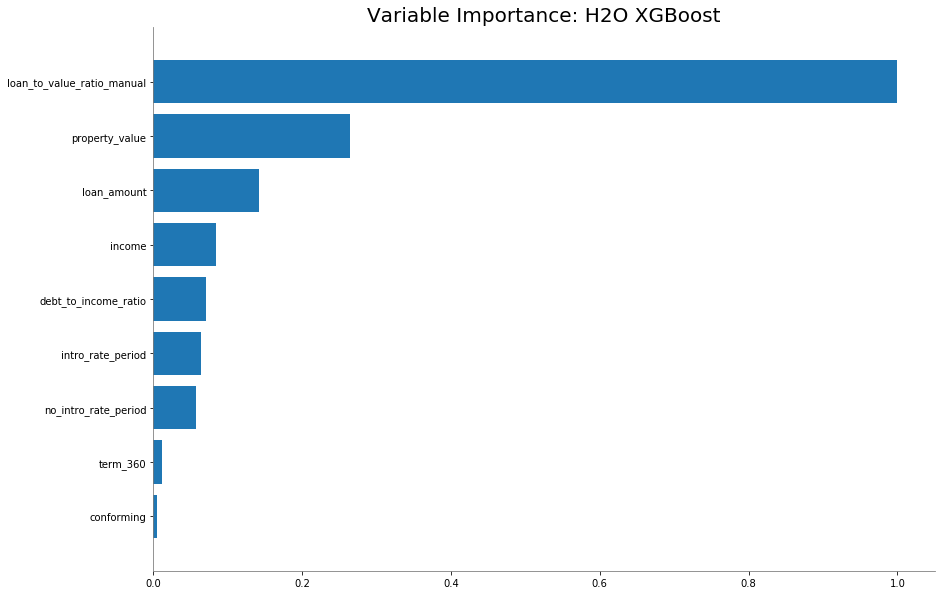

In [101]:
# MXGB var importance
mxgb_default.varimp_plot()

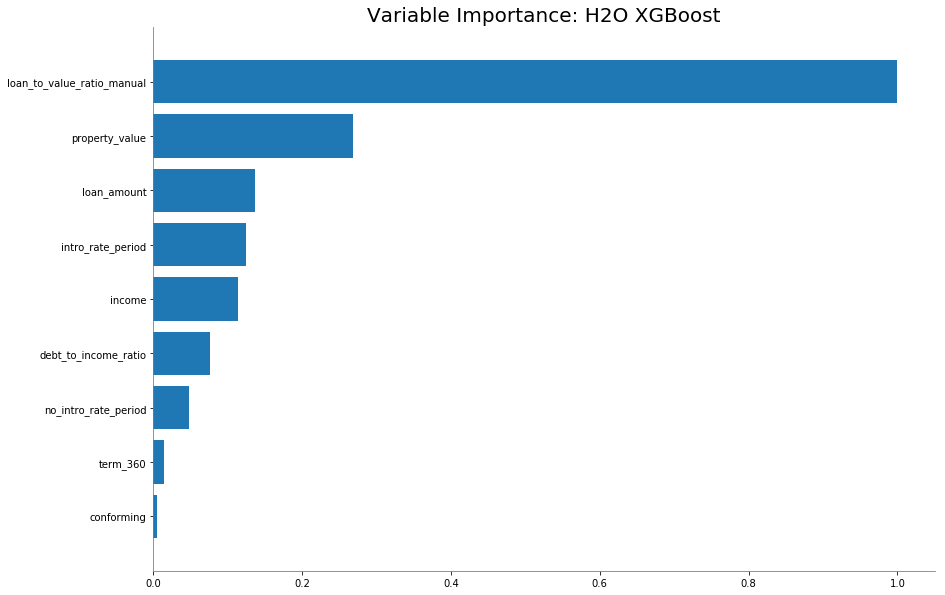

In [102]:
# XGB var importance
xgb_default.varimp_plot()

## Shapey for MXGB

In [103]:
shap_values_mxgb_default, expected_value_mxgb_default = get_shapley(mxgb_default, train, X)

First 5 rows of contributions:



loan_amount,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_to_value_ratio_manual,BiasTerm
-0.471011,-0.111231,-0.0315017,-0.16652,-0.581773,-0.176683,-0.0104093,-0.0093547,-0.144361,0
-0.513632,-0.055733,-0.0334594,-0.402718,-0.296426,-0.196379,0.00109929,-0.0087926,-0.896777,0
0.0852042,-0.556537,-0.367453,0.289793,-0.104346,0.00417602,-0.0152222,-0.0156163,-0.300318,0
-1.39787,-0.15553,-0.146178,-0.644056,-0.359469,-0.392198,-0.00955085,-0.0192388,-2.50976,0
-0.515997,-0.169186,-0.0311406,-0.0419068,-0.388402,-0.0520558,-0.00352642,-0.0191397,0.0756926,0


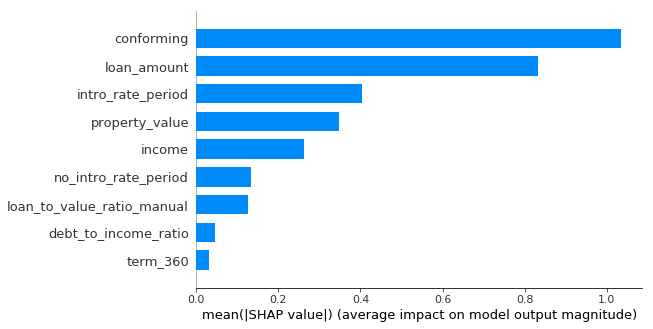

In [104]:
shap.summary_plot(shap_values_mxgb_default, X, plot_type="bar")

## Shapley for XGB

In [105]:
shap_values_xgb_default, expected_value_xgb_default = get_shapley(xgb_default, train, X)

First 5 rows of contributions:



loan_amount,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_to_value_ratio_manual,BiasTerm
-0.288984,-0.187037,-0.0351072,-0.160399,-0.797417,-0.398894,-0.0378785,-0.0022719,0.123239,0
-0.334478,-0.137629,-0.0773872,-0.379693,-1.03264,-0.582187,-0.0166324,-0.0114292,-0.578928,0
-0.322053,-1.0444,-0.574068,-0.0116792,-0.582157,-0.350062,-0.0164623,-0.00392907,-0.125566,0
-0.861987,-0.293496,-0.18215,-0.60977,-0.695596,-0.302599,-0.0594299,-0.00843595,-2.64426,0
-0.209309,-0.183707,-0.0447445,-0.114524,-0.413592,-0.203185,-0.0358272,-0.00222368,0.189756,0


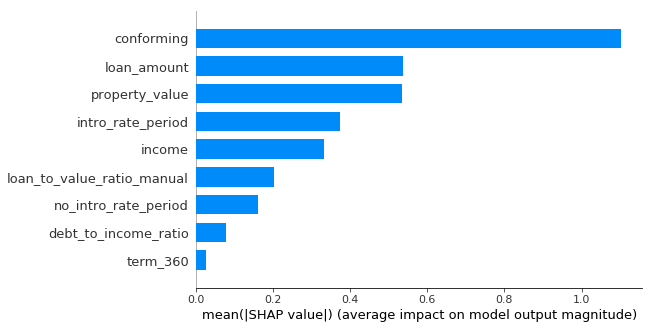

In [106]:
shap.summary_plot(shap_values_xgb_default, X, plot_type="bar")

In [107]:
# GBM hyperparameters
hyper_params = {'learn_rate': [i * 0.01 for i in range(1, 11)],
                'max_depth': list(range(2, 11)),
                'sample_rate': [i * 0.1 for i in range(5, 11)],
                'col_sample_rate': [i * 0.1 for i in range(1, 11)]}

# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 36, 'seed': 1}

# MGBM Grid Search (Constrained)

In [108]:
# Train and validate a random grid of GBMs
mgbm_grid2 = H2OGridSearch(model=H2OGradientBoostingEstimator(distribution='bernoulli',
                    # monotonicity constraints
                    monotone_constraints=mono_constraints,
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='mgbm_grid2',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
mgbm_grid2.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [109]:
# Get the grid results, sorted by validation AUC
mgbm_gridperf2 = mgbm_grid2.get_grid(sort_by='auc', decreasing=True)

In [110]:
print(mgbm_gridperf2)

          col_sample_rate learn_rate max_depth         sample_rate  \
0      0.7000000000000001       0.09        10                 0.5   
1                     0.8       0.09        10  0.7000000000000001   
2                     1.0       0.09        10                 0.9   
3      0.7000000000000001       0.08         9  0.6000000000000001   
4                     1.0       0.09         5                 0.5   
5                     0.9       0.08         6                 0.8   
6                     0.5        0.1         8  0.7000000000000001   
7      0.7000000000000001        0.1         3  0.7000000000000001   
8     0.30000000000000004        0.1         6  0.7000000000000001   
9                     0.9       0.06         6                 0.9   
10                    0.4       0.08         5                 0.8   
11                    0.4       0.07         5                 0.5   
12    0.30000000000000004       0.08         6                 0.8   
13                  

In [111]:
# Grab the top GBM model, chosen by validation AUC
best_mgbm2 = mgbm_gridperf2.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_mgbm_perf2 = best_mgbm2.model_performance(test)

best_mgbm_perf2.auc()

0.7926645658637594

In [112]:
shap_values_mgbm, expected_value_mgbm = get_shapley(best_mgbm2, train, X)

First 5 rows of contributions:



loan_amount,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_to_value_ratio_manual,BiasTerm
0.125114,-0.0110144,0.0335704,0.374322,-0.0848135,0.174554,-0.0160359,-0.01565,0.737945,-2.56847
-0.0381333,-0.0204308,0.0239962,-0.119771,-0.0498963,-0.106671,-0.0158627,-0.0149163,0.369223,-2.56847
0.227979,-0.213439,-0.739064,0.567362,0.00154075,-0.0474809,-0.0211696,-0.0299514,0.38318,-2.56847
-0.107796,-0.0591268,0.0048746,-0.488897,-0.030325,-0.0911042,-0.089554,-0.055971,-1.27046,-2.56847
0.161508,-0.00189342,0.0342786,0.440253,-0.0731936,0.16004,-0.0139975,-0.016649,0.76748,-2.56847


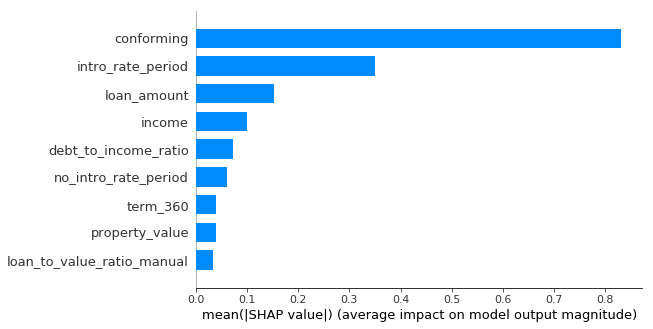

In [113]:
shap.summary_plot(shap_values_mgbm, X, plot_type="bar")

In [114]:
# Save the model
model_path = h2o.save_model(model=best_mgbm2, path="../models/MGBM_BEST_GRID_v2_HMDA_" + str(time.time()), 
                            force=True)

print(model_path)

/home/navdeep/article-information-2019/models/MGBM_BEST_GRID_v2_HMDA_1575672892.3613315/mgbm_grid2_model_36


# GBM Grid Search (Unconstrained)

In [115]:
# Train and validate a random grid of GBMs
gbm_grid2 = H2OGridSearch(model=H2OGradientBoostingEstimator(distribution='bernoulli',
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='gbm_grid2',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
gbm_grid2.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [116]:
# Get the grid results, sorted by validation AUC
gbm_gridperf2 = gbm_grid2.get_grid(sort_by='auc', decreasing=True)

In [117]:
print(gbm_gridperf2)

          col_sample_rate learn_rate max_depth         sample_rate  \
0      0.7000000000000001       0.04         8                 1.0   
1      0.7000000000000001       0.08         9  0.6000000000000001   
2                     0.5        0.1         8  0.7000000000000001   
3                     0.8       0.05        10  0.6000000000000001   
4                     0.9       0.08         6                 0.8   
5                     0.4       0.04         9                 0.5   
6                     0.9       0.04         7                 1.0   
7      0.6000000000000001       0.04         7                 0.8   
8                     0.9       0.06         6                 0.9   
9                     1.0       0.09         5                 0.5   
10     0.7000000000000001       0.09        10                 0.5   
11                    1.0       0.09        10                 0.9   
12                    0.8       0.09        10  0.7000000000000001   
13    0.300000000000

In [118]:
# Grab the top GBM model, chosen by validation AUC
best_gbm2 = gbm_gridperf2.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf2 = best_gbm2.model_performance(test)

best_gbm_perf2.auc()

0.8124064616215078

In [119]:
shap_values_gbm, expected_value_gbm = get_shapley(best_gbm2, train, X)

First 5 rows of contributions:



loan_amount,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_to_value_ratio_manual,BiasTerm
0.101035,-0.00370338,0.000950918,0.427958,-0.124554,0.125213,0.00976564,0.000974446,0.877087,-2.81319
-0.0562617,-0.00823293,0.001908,-0.26225,-0.00816544,-0.191245,0.0119634,0.00331395,0.419676,-2.81319
0.122767,-0.426493,-0.446447,0.496907,0.0071795,0.00766224,0.00433174,0.00425959,0.452571,-2.81319
-0.0628581,-0.0751996,-0.0360053,-0.401479,0.00471389,-0.0474816,0.0123067,0.00376699,-0.981194,-2.81319
0.159789,-0.000899692,0.00361147,0.452915,-0.0520864,0.157529,0.00908281,0.000718363,0.894538,-2.81319


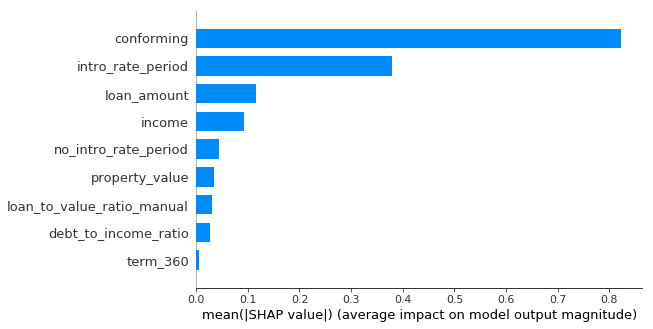

In [120]:
shap.summary_plot(shap_values_gbm, X, plot_type="bar")

In [121]:
# Save the model
model_path = h2o.save_model(model=best_gbm2, path="../models/GBM_BEST_GRID_v2_HMDA_" + str(time.time()), 
                            force=True)

print(model_path)

/home/navdeep/article-information-2019/models/GBM_BEST_GRID_v2_HMDA_1575673317.1858513/gbm_grid2_model_34


# Repeat Previous but with XGBoost

In [122]:
# Train and validate a random grid of XGBoost models
mxgb_grid = H2OGridSearch(model=H2OXGBoostEstimator(distribution='bernoulli',
                    # monotonicity constraints
                    monotone_constraints=mono_constraints,
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    # learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='mxgb_grid2',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
mxgb_grid.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [123]:
# Get the grid results, sorted by validation AUC
mxgb_gridperf = mxgb_grid.get_grid(sort_by='auc', decreasing=True)

In [124]:
print(mxgb_gridperf)

          col_sample_rate learn_rate max_depth         sample_rate  \
0                     0.5        0.1         8  0.7000000000000001   
1                     0.1        0.1        10                 0.5   
2     0.30000000000000004        0.1         6  0.7000000000000001   
3                     0.4       0.08         5                 0.8   
4      0.7000000000000001       0.09        10                 0.5   
5                     0.8       0.09        10  0.7000000000000001   
6     0.30000000000000004       0.08         6                 0.8   
7                     0.2       0.09         6                 1.0   
8                     0.4       0.07         5                 0.5   
9                     0.2       0.06         7                 0.8   
10                    1.0       0.09         5                 0.5   
11     0.7000000000000001       0.08         9  0.6000000000000001   
12                    0.9       0.08         6                 0.8   
13     0.70000000000

In [125]:
# Grab the top GBM model, chosen by validation AUC
best_mxgb = mxgb_gridperf.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_mxgb_perf = best_mxgb.model_performance(test)

best_mxgb_perf.auc()

0.792763514090944

In [126]:
shap_values_mxgb, expected_value_mxgb = get_shapley(best_mxgb, train, X)

First 5 rows of contributions:



loan_amount,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_to_value_ratio_manual,BiasTerm
-0.178396,-0.082587,-0.0606629,-0.244781,-0.457444,-0.148376,-0.00807477,-0.0051053,-0.247129,0
-0.357017,-0.0958708,-0.0975345,-0.605471,-0.238234,-0.279349,-0.00712876,-0.00537641,-0.800813,0
0.0827842,-0.249166,-0.436301,-0.0534158,-0.0842955,-0.0225783,-0.00402391,-0.00253625,-0.296231,0
-0.570682,-0.36148,-0.278085,-0.994785,-0.466622,-0.224587,-0.101773,-0.00582275,-2.3206,0
-0.177537,-0.081961,-0.0526133,-0.194602,-0.330385,-0.0607588,-0.00792974,-0.0067626,-0.172393,0


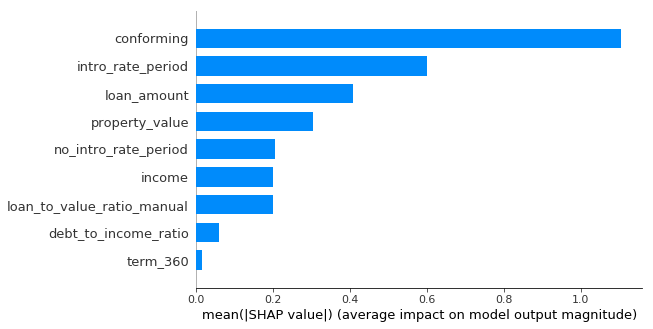

In [127]:
shap.summary_plot(shap_values_mxgb, X, plot_type="bar")

In [128]:
# Save the model
model_path = h2o.save_model(model=best_mxgb, path="../models/MXGB_BEST_GRID_v2_HMDA_" + str(time.time()), 
                            force=True)

print(model_path)

/home/navdeep/article-information-2019/models/MXGB_BEST_GRID_v2_HMDA_1575673909.6351998/mxgb_grid2_model_20


In [129]:
# Train and validate a random grid of XGBoost models
xgb_grid = H2OGridSearch(model=H2OXGBoostEstimator(distribution='bernoulli',
                    # more trees is better if the learning rate is small enough 
                    # here, use "more than enough" trees - we have early stopping
                    ntrees=10000,
                    # learning rate annealing: learning_rate shrinks by 1% after every tree 
                    # (use 1.00 to disable, but then lower the learning_rate)
                    # learn_rate_annealing = 0.99,
                    # score every 10 trees to make early stopping reproducible 
                    # (it depends on the scoring interval)
                    score_tree_interval = 10,
                    # fix a random number generator seed for reproducibility
                    seed = 1234,
                    # early stopping once the validation AUC doesn't improve by at least 0.01% for 
                    # 5 consecutive scoring events
                    stopping_rounds = 5,
                    stopping_metric = "AUC",
                    stopping_tolerance = 1e-4),
                    grid_id='xgb_grid2',
                    hyper_params=hyper_params,
                    search_criteria=search_criteria)
xgb_grid.train(x=X, y=Y,
                training_frame=train,
                fold_column=fold_column,
                ntrees=100,
                seed=SEED)

xgboost Grid Build progress: |████████████████████████████████████████████| 100%


In [130]:
# Get the grid results, sorted by validation AUC
xgb_gridperf = xgb_grid.get_grid(sort_by='auc', decreasing=True)

In [131]:
print(xgb_gridperf)

          col_sample_rate learn_rate max_depth         sample_rate  \
0                     0.9       0.08         6                 0.8   
1                     1.0       0.09         5                 0.5   
2                     0.5        0.1         8  0.7000000000000001   
3     0.30000000000000004        0.1         6  0.7000000000000001   
4                     0.9       0.06         6                 0.9   
5      0.7000000000000001       0.04         8                 1.0   
6     0.30000000000000004       0.04        10                 0.9   
7     0.30000000000000004       0.08         6                 0.8   
8                     0.4       0.04         9                 0.5   
9      0.6000000000000001       0.04         7                 0.8   
10     0.7000000000000001       0.08         9  0.6000000000000001   
11                    0.8       0.05        10  0.6000000000000001   
12                    0.4       0.08         5                 0.8   
13                  

In [132]:
# Grab the top GBM model, chosen by validation AUC
best_xgb = xgb_gridperf.models[0]

# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_xgb_perf = best_xgb.model_performance(test)

best_xgb_perf.auc()

0.813223883258441

In [133]:
shap_values_xgb, expected_value_xgb = get_shapley(best_xgb, train, X)

First 5 rows of contributions:



loan_amount,no_intro_rate_period,intro_rate_period,property_value,income,debt_to_income_ratio,term_360,conforming,loan_to_value_ratio_manual,BiasTerm
-0.206995,-0.0849365,-0.066272,-0.155752,-0.574199,-0.235826,-0.115173,-0.00666707,0.0310854,0
-0.292227,-0.0672074,-0.110013,-0.479755,-0.769329,-0.60829,-0.0477129,-0.00557833,-0.5892,0
-0.0656634,-0.5645,-0.706827,-0.20125,-0.482409,-0.407001,-0.0647695,-0.00311455,-0.0953295,0
-0.574394,-0.19529,-0.277193,-0.740137,-0.556063,-0.176797,-0.0226814,-0.00511853,-2.4389,0
-0.166193,-0.0882621,-0.0640293,-0.120408,-0.415816,-0.153817,-0.11574,-0.00401444,0.00708698,0


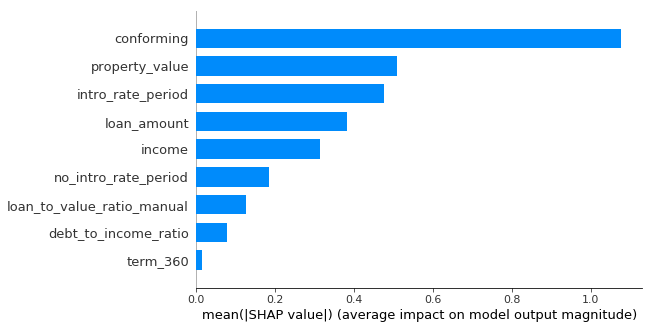

In [134]:
shap.summary_plot(shap_values_xgb, X, plot_type="bar")

In [135]:
# Save the model
model_path = h2o.save_model(model=best_xgb, path="../models/XGB_BEST_GRID_v2_HMDA_" + str(time.time()), 
                            force=True)

print(model_path)

/home/navdeep/article-information-2019/models/XGB_BEST_GRID_v2_HMDA_1575674689.394779/xgb_grid2_model_11
